# 2D Cochlear Traveling Wave Model
The primary goal of this notebook is to allow a user to visualize tonotopicity within the cochlea. Cochlear pressure waves corresponding to a sinusoidal input are generated. This input can be thought of as the fluid-pressure being generated by the stapes striking the oval window.

The user can slide through various input frequencies (between 20 Hz and 20kHz), and see snapshots of the corresponding cochlear waves over length of the basilar membrance (assumed 3.5 cm).

There is also the option of adding time dependence, where animation is used to show the traveling wave over time. Generating the animation's frames could take 5-10 seconds, therefore, an option to skip this feature is provided for quicker viewing of snapshots corresonding to different frequencies.

## Contents
This notebook is organized into the following sections:
1. [Library imports](#1.-Library-Imports)
2. [Constants & model parameters](#2.-Constants-&-Model-Parameters)
3. [Cochlear wave equation](#3.-Cochlear-Wave-Equation)
4. [Plotting functions](#4.-Plotting-Functions)
5. [Animation functions](#5.-Animation-Functions)
6. [Start here](#6.-Start-Here)
7. [Additional plots](#7.-Additional-Plots)
8. [Resonance shift](#8.-Resonance-Shift)
9. [Code references](#9.-Code-References)

### 1. Library Imports

We will use numpy for generating arrays of complex numbers.<br>
The cochlear wave would be animated using *interactive* from ipywidgets.<br>
JavaScript rendering would be used to display the wave animation in-line.

In [1]:
import numpy as np
from math import pi
from numpy import exp, imag, trapz, cos, log10, angle
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
rc('animation', html='jshtml')
#rc('animation', html='html5') # requires ffmpeg, skip

### 2. Constants & Model Parameters

Deafult values for various modeling parameters are defined below.

Some of these parameters will be scaled later to explore the cochlear wave's sensitivity to mass, stiffness, and resistance.

In [2]:
#---------------------------------------------------------------------#
# Cochlear parameters
#---------------------------------------------------------------------#

RHO = 1 # g/cm^3, density of cochlear fluid
M = .01 # g/cm^2, mass/area of the basilar membrane
P0 = 2 # dyne/cm^2, pressure at the base of the cochlea (x=0)
S0 = 2e8 # dyn/cm^3, cochlear stiffness (max)
R0 = 5 # dyn.s/cm^3, cochlear resistance (max)
#---------------------------------------------------------------------#
# Constants used for handling equations
#---------------------------------------------------------------------#
# Set bounds for the slider that the user will use to provide freq input
freqHz_MIN = 2e1 # lower bound
freqHz_MAX = 2e4 # upper bound

j = 1j # complex!
dt = 1/freqHz_MAX/10 # seconds, time step for animation, this seemed to work (maybe we can adapt the grid)
dx = 0.01 # cm, step size on x, again seemed to work
xx = np.arange(0, 3.5, dx) # cm, array of all position values to be used throughout the notebook

### 3. Cochlear Wave Equation

Guts of the model!

In [3]:
def make_cochlear_wave_at(fHz, \
                          m = M, rho = RHO, s0 = S0, r0 = R0):
    w = 2*pi*fHz
    s_x = s0 * exp(-1.5*xx) # dyn/cm^3
    r_x = r0 * exp(2.25*xx) # dyn.s/cm^3
    
    Z_x = r_x + j*(m*w - s_x/w)
    Y_x = 1/Z_x

    # Do the intergral
    P_x = []
    for ndx in range(len(xx)):
        integralY = trapz(Y_x[:ndx], x=xx[:ndx])
        P_x.append(P0*exp(-w*rho*2*integralY))

    # Get mag/phase
    P_x = np.array(P_x) # for vector math
    Pmag = abs(P_x)
    Prad = angle(P_x, deg=False) # use radians
    
    return Pmag, Prad, Z_x

### 4. Plotting Functions

Two plotting functions are provided:
* A magnitude/phase plot, used to show cochlear pressure/velocity/displacement below
* A real/imaginary plot, used to show components of impedence/admittance below

Calling either function from a notebook cell generates the corresponding plot in-line. Also, text string inputs can be provided for specifying the title and y-axis units for each plot.

In [4]:
#---------------------------------------------------------------------#
# generate mag/phase and wave plot
#---------------------------------------------------------------------#

def plot_mag_phase(complexVar, titleStr, ampUnits):
    mag = abs(complexVar) # extract mag/phase of veolcity
    rad = angle(complexVar, deg=False) # use radians

    # Unwrap the phase
    rad_uw = np.unwrap(rad) # unwrap the phase
    cyc_uw = rad_uw / (2*pi) # 2pi rad is one cycke: covert to cycles

    # Mag plot
    ax1 = plt.subplot(211)
    ax1.plot(xx, mag, 'r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_ylabel('Amplitude\n[{}]'.format(ampUnits), color='r')

    # phase plot of secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(xx, cyc_uw)
    ax2.tick_params(axis='y', labelcolor='#1f77b4')
    ax2.set_ylabel('Phase\n[cycles]', color='#1f77b4')

    plt.title(titleStr)
    plt.grid(axis='both')

    # real wave plot
    ax3 = plt.subplot(212)
    ax3.plot(xx, mag*cos(rad), 'r')
    ax3.tick_params(axis='y', labelcolor='r')
    ax3.set_ylabel('[{}]'.format(ampUnits), color='r')
    ax3.set_xlabel('[cm]')

    plt.grid(axis='both')
    
#---------------------------------------------------------------------#
# generate real/imag plot
#---------------------------------------------------------------------#

def plot_real_imag(complexVar, titleStr, unitStr = ''):
    real = complexVar.real
    imag = complexVar.imag

    # plot real part (over x)
    fig1, ax1 = plt.subplots()
    ax1.plot(xx, real, 'r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_xlabel('[cm]')
    ax1.set_ylabel('Real', color='r')

    # plot imaginary part (over x)
    ax2 = ax1.twinx()
    ax2.plot(xx, imag)
    ax2.tick_params(axis='y', labelcolor='#1f77b4')
    ax2.set_ylabel('Imag', color='#1f77b4')

    plt.title('{}\n[{}]'.format(titleStr, unitStr))
    plt.grid(axis='both')

### 5. Animation Functions

Animating is handled in three steps:
1. A static figure is generated with containers to hold plotting data
2. The animation function itself, which generates plotting data corresponding to each frame in the animation
3. A user-input handler, that will kick off the frame generation when the user provides an input frequency below

In [5]:
#---------------------------------------------------------------------#
# figure setup
#---------------------------------------------------------------------#

fig0, ax0 = plt.subplots() # generates empty plot, skip with %%capture?
plt.xlim((0, 3.5))
plt.ylim((-1.1*P0, 1.1*P0))
plt.xlabel('[cm]')
plt.ylabel('[dyn / $cm^2$]')
plt.title('Basilar Membrane: Pressure Wave')
plt.close() # just to remove the empty plot, fig0/ax0 will persist

line, = ax0.plot([], [], lw=2)
line_env, = ax0.plot([], [], 'r--', lw=1) # for mag envelope
line_env_bottom, = ax0.plot([], [], 'r--', lw=1) # for mag envelope

#---------------------------------------------------------------------#
# plot the background of each frame
#---------------------------------------------------------------------#

def plot_init():
    line.set_data([], [])
    line_env.set_data([], [])
    line_env_bottom.set_data([], [])
    return (line, line_env, line_env_bottom)

#---------------------------------------------------------------------#
# animation function
#---------------------------------------------------------------------#

def update(ndx, Pmag, Prad, freqHz, freezeTime):
    
    if freezeTime:
        y = Pmag*cos(Prad)
    else: # shift phase over time
        w = 2*pi*freqHz
        y = Pmag*cos(Prad + w*ndx*dt)
        
    # update plot
    line.set_data(xx, y)
    line_env.set_data(xx, Pmag)
    line_env_bottom.set_data(xx, -Pmag)
    return (line, line_env, line_env_bottom)

#---------------------------------------------------------------------#
# run this whenever user updates freqency input
#---------------------------------------------------------------------#

def user_inputs(freqHz, freezeTime):
    
    freqHz = round(freqHz, 2) # round to two decimals for cleaner prints
    
    Pmag, Prad = make_cochlear_wave_at(freqHz)[:2]
    T = 1/freqHz # period of one visual
    delay_ms = 20 # for changing rate of animation
    
    if freezeTime: # just to skip calculating animation frames
        numSteps = 1
        
        print('Use slider to see pressure wave snapshots @ different freqs')
        print('Please select "freezeTime" to see time variation')
        print('Input freq = {} Hz'.format(freqHz))
        
    else:
        numSteps = int(T/dt) # create enough steps to cover one entire period
        print('Input freq = {} Hz'.format(freqHz) +\
              '\nCorresponding period = {} s'.format(T) +\
              '\nTimestep \u0394t = {} us'.format(dt*1e6) +\
              '\nGenerating {} frames to span one T...please wait...'.format(numSteps))
        
        print('Click the play button!')
    
    # call the animator
    ani = animation.FuncAnimation(fig0, update, \
                                   init_func=plot_init, \
                                   fargs=(Pmag, Prad, freqHz, freezeTime),\
                                   frames=numSteps, interval = delay_ms, \
                                   blit=True, repeat=True)
    
    return ani

### 6. Start Here

This section is interactive! Clicking on the input widgets below will update the visuals!

Here are the two inputs the user can provide:
1. freqHz
    * User can pick an input frequency for the cochlear pressure wave. This can be thought of as the frequency of the pressure in the cochlear fluids. Note that the pressure amplitude at the apex of the basilar membrane was defined ealier, under [Constants & model parameters](#2.-Constants-&-Model-Parameters)
    * Wave generation/plotting code gets exceuted when the user releases the slider. Therefore, interaction isn't quite real-time...
    * type: float (gets rounded down to two decimals)
    * default value: **4kHz**
2. freezeTime
    * when selected (checked), we skip generating animation frames. This allows for faster viewing of pressure plots corresponding to different input frequencies.
    * when disabled, animation frames are generated and rendered as a video. User must hit 'play' to see the time-variation
    * type: boolean
    * default: **true**, that is, skip animation

In [6]:
#---------------------------------------------------------------------#
# Get f from user
#---------------------------------------------------------------------#

ani = interact(user_inputs, freezeTime=True, \
               freqHz=widgets.FloatLogSlider(value=4000, base=10,\
                                             min=log10(freqHz_MIN), max=log10(freqHz_MAX), step=.1, \
                                             continuous_update=False)) # only run on mouse release
ani # show the plot using javascript

interactive(children=(FloatLogSlider(value=4000.0, continuous_update=False, description='freqHz', max=4.301029…

<function __main__.user_inputs(freqHz, freezeTime)>

### 7. Additional Plots

Note: the user must assign the input frequency again for this section. See "freq" assignment below.
This is defaulted to 2kHz.

The given frequency is used to generate a cochlear pressure wave as above.
Then we derive the corresponding velocity and displacement of the cochlea (the basilar membrane). 

All plots are generated with respect to position, as we step from the base to the apex of the cochlea.

Impedance and admittance plots are also generated.

In [7]:
freq = 2e3 #600 #2e3 #6e3 # input frequency used for generating plots below

#---------------------------------------------------------------------#
# Make calculations for the plots below
#---------------------------------------------------------------------#

# We can run various cases. Just un-comment wave calculation calls to explore variation over m, s, and r
Pmag, Prad, Z = make_cochlear_wave_at(freq) # Default case
#Pmag, Prad, Z = make_cochlear_wave_at(freq, m=0) # eliminate mass dependence (inductance)
#Pmag, Prad, Z = make_cochlear_wave_at(freq, r0=R0/10) # decrease resistance (dissipation)
#Pmag, Prad, Z = make_cochlear_wave_at(freq, s0=S0*10) # increase stiffness (capacitance)
#Pmag, Prad, Z = make_cochlear_wave_at(freq, m=m_pk) # must have executed section #8 first
#Pmag, Prad, Z = make_cochlear_wave_at(freq, m=m_pk, r0=R0/10) # must have executed section #8 first

Y = 1/Z
P = Pmag*exp(j*Prad) # regenerate complex waveform for deriving v, d
V = 2*P*Y
D = V/j/(2*pi*freq)

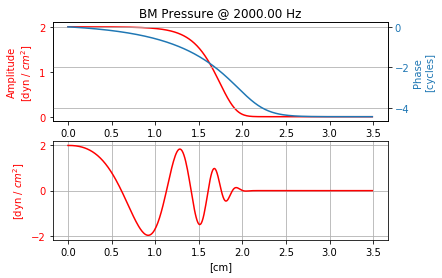

In [8]:
heading = 'BM Pressure @ {:.2f} Hz'.format(freq)
plot_mag_phase(P, heading, 'dyn / $cm^2$')

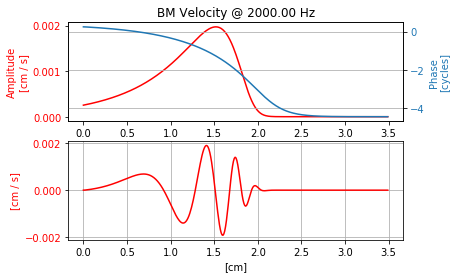

In [9]:
heading = 'BM Velocity @ {:.2f} Hz'.format(freq)
plot_mag_phase(V, heading, 'cm / s')

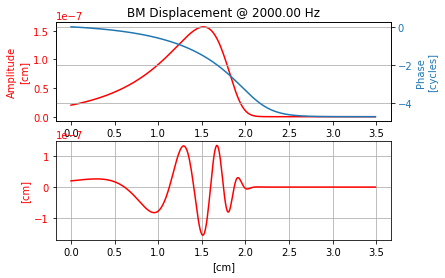

In [10]:
heading = 'BM Displacement @ {:.2f} Hz'.format(freq)
plot_mag_phase(D, heading, 'cm')

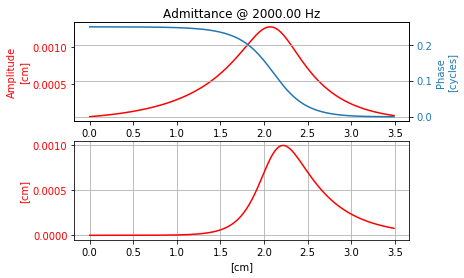

In [11]:
heading = 'Admittance @ {:.2f} Hz'.format(freq)
plot_mag_phase(Y, heading, 'cm')

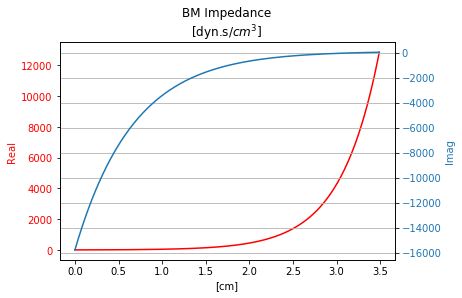

In [12]:
plot_real_imag(Z, 'BM Impedance', 'dyn.s/$cm^3$')

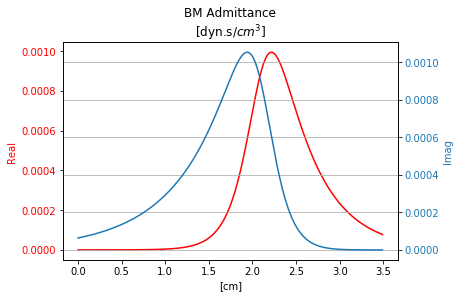

In [13]:
plot_real_imag(Y, 'BM Admittance', 'dyn.s/$cm^3$')

### 8. Resonance Shift

Here we try to identify a membrane mass/area that would show us a peaking response for a given input frequency at a target distance along the BM.

In [14]:
w = 2*pi*freq
x_pk = 1.5 # cm
s_pk = S0 * exp(-1.5*x_pk) # dyn/cm^3
m_pk = s_pk / (w**2)
print('m={:.2f}g/cm^2 to have pressure input @ {}Hz resonating at x={}cm'.format(m_pk, freq, x_pk))

m=0.13g/cm^2 to have pressure input @ 2000.0Hz resonating at x=1.5cm


### 9. Code References
Generating the table of contents with anchored links:
- https://sebastianraschka.com/Articles/2014_ipython_internal_links.html

Animating in Jupyter:
- http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
- http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
- https://stackoverflow.com/questions/16732379/stop-start-pause-in-python-matplotlib-animation

In [15]:
import matplotlib
matplotlib.__version__

'3.1.1'

In [16]:
np.version.version

'1.17.2'